In [3]:
from ..helpers.dataset import Dataset

ImportError: attempted relative import with no known parent package

In [1]:
# all the required python packages
import sys
import os

# uncomment when you are running for first time
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install deepface
# !{sys.executable} -m pip install pillow
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install mediapipe
# !{sys.executable} -m pip install roboflow
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install joblib
# !{sys.executable} -m pip install dlib

DATA_DIR = './_data'
ROBO_DIR = DATA_DIR + '/robo'
WFACE_DIR = DATA_DIR + '/wider_face'
ROBO_WORKSPACE = 'nitesh-c-eszzc' # change it

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(ROBO_DIR, exist_ok=True)
os.makedirs(WFACE_DIR, exist_ok=True)

# 1. Problem Statement

**Objective:**
Propose an innovative solution that focuses on individualizing emotion recognition within groups using advanced deep learning techniques, including face detection and pre-trained emotion recognition models.

**Previous Work:**
Some previous approaches have attempted to address this issue by employing combinations of convolutional neural networks (CNNs) and long short-term memory networks (LSTMs) to extract features from both whole images and facial regions or fusing results from individually trained CNNs on faces and whole images.

**Ask:**
Aim to break down group images, acknowledge the unique emotional expressions of each individual, and improve the accuracy and nuance of group-level emotion recognition. Primary goal is to showcase the power of integration and adaptation of existing technologies for cohesive group recognition.

# 2. Introduction

Group cohesiveness (motivation here) refers to the bonding between indiviudals within a group. (ref: [wiki](https://en.wikipedia.org/wiki/Group_cohesiveness)). The wiki lists cohesion is influenced by multiple factors and emotion is one of the important one. Emotions are conveyed through multiple channels, including facial expressions, vocal intonations, and body language.(ref: problem statement). I will be focusing on facial expressions.

**Data challenge** 

The problem statement talks about the facial expression prediction in the wild on images and videos. I will be focusing on static images in this notebook. The complications with static images include - face occlusions, illumination variations, head pose variations, varied indoor and outdoor settings, faces at different distances from the camera, and low-resolution face images. (ref: [paper](https://arxiv.org/pdf/1910.01197.pdf)). We need to choose a model trained on in the wild dataset for a better performance.

**Approach** 

Predicting facial expression of each individual in the group requires detecting all the faces in the group and then recognizing the facial expression of each face. I will attempt to find model which are good at detecting faces, then extract the faces and then feed into the model which is good at recognizing facial expressions (FER). The predicted individual facial expressions can be leveraged to predict the group cohesivenes along with other attributes - scene, pose, etc..(ref: [EmotiW](https://cs.uwaterloo.ca/~jhoey/papers/DhallEmotiW2017.pdf)) which out of scope of this notebook.

Here is what I attempt to do to start with,
```
    Images -> FD model -> Extract Faces -> FER model -> Expressions -> Evaluate
```


**Face Detection**:
[WIDERFACE](http://shuoyang1213.me/WIDERFACE/) dataset is a face detection benchmark dataset with varied images taken from internet. All the face detecton models publish results based on this dataset. I will attempt to find the (pretrained) model which did best on the above dataset and leverage for the problem at hand.

paperswithcode.com is a community site which publishes the best models for a given dataset. For WIDERFACE dataset (2) - there are multiple models which did above 96% on mAP. 

[ASFD](https://arxiv.org/pdf/2201.10781v1.pdf) - 97.2%  - Jan 2021;

[TinaFace](https://arxiv.org/pdf/2011.13183v3.pdf) - 97% mAP - Jan 2021; 

[RetinaFace](https://arxiv.org/pdf/1905.00641.pdf) - 96.9% mAP; 

[YOLOv5 Face](https://arxiv.org/pdf/2105.12931.pdf) - 96.6% mAP - Jan 2022; 

[LAFD based on RetinaFace](https://arxiv.org/pdf/2308.04340.pdf) - 94.3 - Aug 2023 with model size of 10.2 MB.

**Face Expression Recognition**:
FER2013 contains approximately 30,000 facial RGB images of different expressions with size restricted to 48×48, and the main labels of it can be divided into 7 types: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral. The Disgust expression has the minimal number of images – 600, while other labels have nearly 5,000 samples each.

For [FER2013](https://paperswithcode.com/sota/facial-expression-recognition-on-fer2013) & [FERPlus](https://paperswithcode.com/sota/facial-expression-recognition-on-fer-1) datasets, paperswithcode.com lists [PAtt-Lite](https://arxiv.org/pdf/2306.09626v1.pdf) as best model (with 92.5% AP on FER2013 and 95.55 AP on FER+ dataset) and few other models with over 90% AP.

[PAtt-Lite](https://arxiv.org/pdf/2306.09626v1.pdf) paper refers other models with over 90% AP which it out performs - [CIAO](https://arxiv.org/abs/2208.07221), [POSTER](https://arxiv.org/abs/2301.12149)


**deepface**:

I came across an open source library - [deepface](https://github.com/serengil/deepface) by Sefik Ilkin Serengil. The library exposes api to leverage various SOA models - opencv (Haar Cascade), SSD, DLib (HOG), MTCNN, RetinaFace, MediaPipe - as backends to detect faces and uses custom model to extract facial attributes - age, race, gender, emotion. The custom model constitutes 4 blocks - 3 CNN blocks followed by a Fully connected block. 
```
    [Softmax -> facial-expression probabilities]
    [Dense, Dropout, Dense, Droupout]
    [Flatten]
    [CNN -> CNN -> AvgPool]
    [CNN -> CNN -> AvgPool]
    [CNN -> CNN -> MaxPool]
    [i/p: images]
```

I will start with this open source library using different backends provided as its fit the usecase. If time allows, I will try using Yolov8, TinaFace for backend and code up PAtt-Lite for FER.


**Evaluation:**

The motivation behind recognizing the facial expressions is to predict the group cohesiveness. Group cohesiveness is strongly related to the emotion which can be understood through scene, body and facial features together. The scene features encodes fashion, makeup, place setting, etc.., the body features encode the body pose in relation to others in group, and facial features encodes the expressions (ref: [1](https://arxiv.org/pdf/1910.01197.pdf), [2](https://arxiv.org/pdf/1812.11771.pdf)). Our interest in this task is to evaluate how good we can predict the faces & expressions in a way they influence the group cohesiveness (ref: [paper](https://arxiv.org/pdf/1812.11771.pdf)).

The dataset we are interested are the pictures taken in the wild which includes complications - face occlusions, illumination variations, head pose variations, varied indoor and outdoor settings, faces at different distances from the camera, and low-resolution face images. Its important that we take a good combination of these complications to evaluate the model on hand. [WIDERFACE](http://shuoyang1213.me/WIDERFACE/) dataset has additional metadata to describe the image - setting/group, scale, blur, illumination, occlusion, expression, and pose. I will leverage these attributes to randomly select images from testset, annotate the faces with expression using roboflow.com and then use for the evaluation. 

The model chosen for evaluation tries to predict the face region and facial expression of every face in the image. From group cohesive prediction context, we are interested more in the composition of facial expressions and not necessarily the face regions. For example, this [paper]( https://arxiv.org/pdf/1812.11771.pdf) takes the max, min and avg facial expression probabilities as features to cohesion prediction layer. Although predicting faces accurately is necessary to accurately predict the facial expression, its doesn't directly influence the output. For this reason, I will evaluate the model based on composition of 7 emotions - "angry", "disgust", "fear", "happy", "sad", "surprise", "neutral". 

I will use BLEU-1 (1 gram) score for evaluation by sorting the tokens in a sorted order.  The BLEU score accounts for the repeated tokens and length of sentence. It evaluates the similarity in the range 0 - 1, where 1 being the exact match both on number of faces and composition of facial expressions and 0 being no match. [intepretation of BLEU score](https://cloud.google.com/translate/automl/docs/evaluate#bleu)

Here are few examples in decreasing order of similarity:
```
actual: 'happy'         pred: 'happy'       ->  score: 1
actual: 'happy happy'   pred: 'happy sad'   ->  score: 0.62
actual: 'happy happy'   pred: 'happy'       ->  score: 0.30
actual: 'happy'         pred: 'sad sad'     ->  score: 0.14
actual: 'happy'         pred: 'sad'         ->  score: 0.17
actual: 'happy happy'   pred: 'sad'         ->  score: 0.023
actual: 'happy'         pred: ''            ->  score: 0
```


I will evaluate different pre-trained models (with different parameters) based on BLEU-1 score, pick a best model and look at the results in min, median and high score ranges.


**Side Notes:** 
- Across my search on internet, I see we face detection and face expression models have their own backends. I don't see them sharing the same backend to do both (e.g Yolo/SSD vs R-CNN). This might be area of research. 
- mAP is the most used metric in the papers, my research included trying to see the best model based on this metric for this excercise. There are other parameters - latency, model size, etc. which need be consider based on use case.



# 3. Prepare Dataset
- Downlaod WIDERFACE dataset (choosing validation as it has less images)
- Randomly choose 300 images with evenly spreaded across attributes - blur, illumination, pose, makeup, situratio, group size
- Upload the selected images to roboflow.com
- Manually label the faces with angry, disgust, fear, happy, neutral, sad, surprise
- Download the dataset from roboflow

### Download WIDERFACE Validation dataset

In [2]:
from widerface import WiderFaceManager

mgr = WiderFaceManager(root_dir=WFACE_DIR)
wface_val_df = mgr.get_val_reader().read()
wface_val_df.head()

,img_path,group,face,x,y,w,h,blur,expression,illumination,invalid,occlusion,pose
0,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,0,345,211,4,4,2,0,0,0,2,0
1,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,1,331,126,3,3,0,0,0,1,0,0
2,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,2,250,126,3,4,2,0,0,0,2,0
3,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,3,221,128,4,5,0,0,0,1,0,0
4,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,4,427,116,3,4,2,0,0,0,2,0


### Randomly choose around 300 images for validation with even spread on image attributes

In [3]:
from widerface import WiderFaceSelector

rnd_wface_df = WiderFaceSelector(wface_val_df, size=300).select()
print(len(rnd_wface_df), 'faces selected')

rnd_wface_df.head()

4978


,img_path,group,face,x,y,w,h,blur,expression,illumination,invalid,occlusion,pose
126,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,0,26,299,10,16,2,0,0,0,2,0
127,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,1,25,329,7,11,2,0,0,0,1,0
128,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,2,84,341,6,8,2,0,0,0,1,0
129,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,3,80,329,5,6,2,0,0,0,2,0
130,./_data/wider_face/val/images/WIDER_val/images...,0--Parade,4,110,335,4,9,2,0,0,0,2,0


### Upload the images to roboflow and annotate the faces with facial expressions 

In [8]:
import shutil

from pathlib import Path
import numpy as np

import roboflow
from robowrapper import RoboProj, RoboProjCreator
from robowrapper import RoboYoloDataset

from dataset import YoloDatasetBuilder
from imagewrapper import CVImageWrapper

# it will prompt for a token
# check the log below for the url to generate token 
roboflow.login()
rf = roboflow.Roboflow()

FER_PROJ_NAME = 'fer-wider-face-val-mini'
FER_PROJ_DIR = ROBO_DIR+'/'+FER_PROJ_NAME

# create project and upload the selected files
fer_proj = RoboProjCreator(
    rf, 
    proj_name=FER_PROJ_NAME,
    proj_ann='facial-expressions',
    proj_type='object-detection',
    workspace=ROBO_WORKSPACE).create()

fer_ds = RoboYoloDataset(root_dir=FER_PROJ_DIR)
fer_ds.create_tag('valid')

fer_img_dir = fer_ds.images_dir['valid']
fer_ann_dir = fer_ds.labels_dir['valid']
yolo_ds_builder = YoloDatasetBuilder()
for index, row in rnd_wface_df.iterrows():
    img_name = Path(row['img_path']).name
    img_path = fer_img_dir+'/'+img_name
    ann_path = fer_ann_dir+'/'+img_name.replace(Path(img_name).suffix, '.txt')
    
    if not os.path.exists(img_path):
        shutil.copy(row['img_path'], img_path)
        
    img = CVImageWrapper(img_path)
    bbox = row[['x', 'y', 'w', 'h']].to_numpy()
    nbbox = img.normalize_bboxes(np.array([bbox]))[0]
    img_id = yolo_ds_builder.add_image(img_path)
    
    #default to 0 category
    yolo_ds_builder.add_annotation(img_id, category_id=0, bbox=nbbox)

yolo_ds_builder.build().to_file(fer_ann_dir)

#refresh the robo dataset after the files
fer_ds = RoboYoloDataset(fer_ds.root_dir)

#uncomment below line to upload to roboflow
#fer_proj.upload(fer_ds)

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


### Manually annotate the faces with facial expressions 
- Access https://app.roboflow.com
- Navigate to project 'fer-wider-face-val-mini'
- Browse images and annotate with labels - angry, disgust, fear, happy, sad, surprise. You can leave neutral as '0' (the tag we uploaded with)
- Duplicate the project to fer-wider-face-mini
- Generate a version on fer-wider-face-mini with only the pre-processing step of mapping label '0' to 'neutral'
- Make a note of the version. You can access the dataset using url ```https://app.roboflow.com/nitesh-c-eszzc/fer-wider-face-mini/1```


# 4. Download Dataset

Downloaded the prepared data.

url: https://app.roboflow.com/nitesh-c-eszzc/fer_wider_face_mini/1

In [12]:
import roboflow

from robowrapper import RoboProj
from dataset import COCODatasetBuilder
from imagewrapper import ImageIterator

SAMPLE_IMG_NAME = 'fer_wider_face_sample_jpg'
sample_img_path = None

roboflow.login()
rf = roboflow.Roboflow()

# 'nitesh-c-eszzc/fer-wider-face-mini' is a public dataset, anyone can download
# in case you followed all the steps replace 'nitesh-c-eszzc' with ROBO_WORKSPACE
proj_wfacemini =  RoboProj(
    rf, 
    rf_proj=rf.project('nitesh-c-eszzc/fer_wider_face_mini'),
    proj_ver=1
)
ds_wfacemini = proj_wfacemini.download(
    dataset_path=ROBO_DIR+'/fer-wider-face-mini',
    dataset_format='coco')
wfacemini_val_dir = ds_wfacemini.get_all_images_dir()[0]
coco_ds = COCODatasetBuilder.build_from_file(ds_wfacemini.get_all_labels_dir()[0])

img_itr = ImageIterator(wfacemini_val_dir)
for img_path in img_itr:
    if SAMPLE_IMG_NAME in img_path:
       sample_img_path = img_path
       break 

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).



Extracting Dataset Version Zip to ./_data/robo/fer-wider-face-mini in coco:: 100%|██████████| 311/311 [00:00<00:00, 630.49it/s]


randomly check an image from dataset with ground truth labels

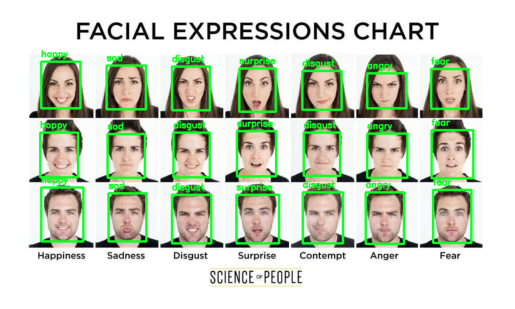

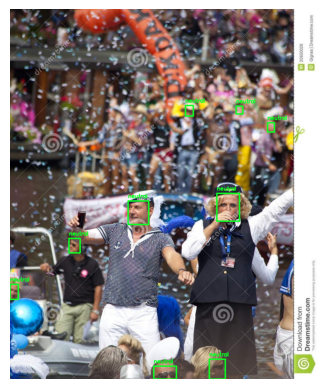

In [13]:
import random
import numpy

from imagewrapper import ImageIterator
from imagewrapper import CVImageWrapper
from matplotlib import pyplot as plt

from pathlib import Path

img = CVImageWrapper(sample_img_path)
anns = coco_ds.get_bbox(Path(sample_img_path).name)
labels = [a[0] for a in anns]
bboxes = numpy.array([a[1] for a in anns])
img.annotate(bboxes, labels)
img.imshow(plt)


img_itr = ImageIterator(wfacemini_val_dir)
rand_img_path = img_itr[random.randint(0, len(img_itr)-1)]

img = CVImageWrapper(rand_img_path)
anns = coco_ds.get_bbox(Path(rand_img_path).name)
labels = [a[0] for a in anns]
bboxes = numpy.array([a[1] for a in anns])
img.annotate(bboxes, labels)
img.imshow(plt)



# 5. Evaluate

### Define Evaluator

In [14]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

class GroupFEREvaluator:
    def sentencify(labels):
        return ' '.join(sorted(labels))
        
    def evaluate_one(actual_labels, predict_labels):
        ref = GroupFEREvaluator.sentencify(actual_labels)
        cand = GroupFEREvaluator.sentencify(predict_labels)
        return round(sentence_bleu([ref], cand, weights=[1]), 2)
    
    def evaluate_all(tuples):
        refs = [ [GroupFEREvaluator.sentencify(r)] for r,_ in tuples]
        cands = [ GroupFEREvaluator.sentencify(c) for _,c in tuples]
        return round(corpus_bleu(refs, cands, weights=[1]), 2)

print(GroupFEREvaluator.evaluate_one(['angry'], ['sad']))
print(GroupFEREvaluator.evaluate_all([(['angry'], ['sad'])]))

0.17
0.17


### Define Model

The model defines wrapper over the [deepface](https://github.com/serengil/deepface/tree/master) module. It accepts different backends supported by deepface. Additionaly it accepts the emotion threshold and the default empotion, which is leveraged to default the emotion to 'neutral' if the model is not confident, which is what I did when I annotated the faces on roboflow for the validation dataset.

In [27]:
from deepface import DeepFace
import numpy as np

class DeepFaceWrapper:
  def __init__(
    self,
    backend='retinaface', 
    emotion_threshold=0.5,
    default_emotion='neutral'
  ) -> None:
    self.img_path = img_path
    self.backend = backend
    self.emotion_threshold = emotion_threshold
    self.default_emotion = default_emotion
  
  def _to_bboxes(self, face_objs):
    return np.array([
      np.array([
          face['region']['x'], 
          face['region']['y'], 
          face['region']['w'], 
          face['region']['h']
      ]) for face in face_objs
    ])
  
  def _to_labels(self, face_objs):
    def _to_emotion(face):
      dominant_emotion = face['dominant_emotion']
      if face['emotion'][dominant_emotion] > self.emotion_threshold:
        return dominant_emotion
      else:
        return self.default_emotion
    return [ _to_emotion(face) for face in face_objs]
  
  def predict(self, img_path):
    face_objs = DeepFace.analyze(
        img_path = img_path,
        detector_backend = self.backend,
        enforce_detection=False,
        actions = ['emotion'], align=True, silent=True
      )
    return (self._to_labels(face_objs), self._to_bboxes(face_objs))

# below backend are availabel from the deepface library
backends = [
  'opencv', 
  'ssd', 
  # 'dlib', #have issues downloading dlib
  'mtcnn', 
  'retinaface', 
  'mediapipe'
]

Try out the model with a sample and random image from dataset

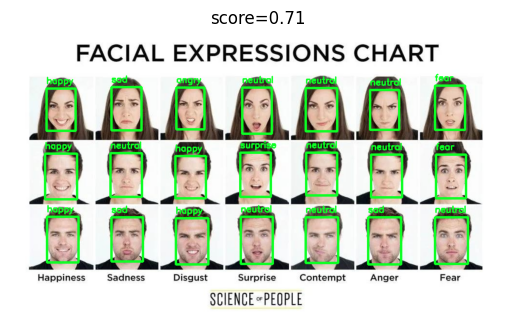

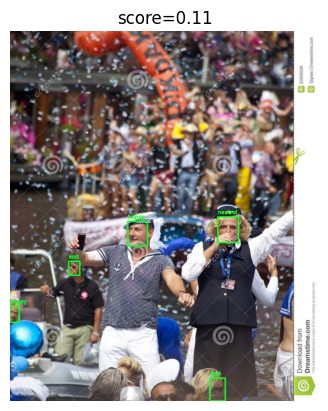

In [16]:
from imagewrapper import CVImageWrapper
from matplotlib import pyplot as plt
from pathlib import Path

# predict & evaluate for sample image
labels, bboxes = DeepFaceWrapper().predict(sample_img_path)
img = CVImageWrapper(sample_img_path)
img.annotate(bboxes, labels)
actual_labels = [a[0] for a in coco_ds.get_bbox(Path(sample_img_path).name)]
score = GroupFEREvaluator.evaluate_one(actual_labels, labels)
plt.title('score='+str(score))
img.imshow(plt)

# predict & evaluate for random image
labels, bboxes = DeepFaceWrapper().predict(rand_img_path)
img = CVImageWrapper(rand_img_path)
img.annotate(bboxes, labels)
actual_labels = [a[0] for a in coco_ds.get_bbox(Path(rand_img_path).name)]
score = GroupFEREvaluator.evaluate_one(actual_labels, labels)
plt.title('score='+str(score))
img.imshow(plt)

### Declare models to evaluate

In [19]:
class ModelTester:
    def __init__(self, backend='retinaface', emotion_threshold=0.5) -> None:
        self.name  = '{}-{}-{}'.format('deepface', backend, emotion_threshold)
        self.model_obj = DeepFaceWrapper(backend=backend, emotion_threshold=emotion_threshold)
        self.model = lambda x: self.model_obj.predict(x)
        self.evaluator = lambda x: GroupFEREvaluator.evaluate_all(x)
        self.truth_getter = lambda x: [a[0] for a in coco_ds.get_bbox(Path(x).name)]
    
    def test(self, itr) -> float:
        tuples = []
        results = {}
        
        for img_path in itr:
            labels, bboxes = self.model(img_path)
            actual_labels = self.truth_getter(img_path)
            tuples.append((actual_labels, labels))
            
            results[img_path] = {
                'labels': labels,
                'bboxes': bboxes,
                'actual_labels': actual_labels,
                'score': self.evaluator([(actual_labels, labels)])
            }
        score = self.evaluator(tuples)
        return score, results

In [34]:
from joblib import Parallel, delayed

def run_models(models, data, jobs=4):
    parallel = Parallel(n_jobs=jobs, return_as="generator")
    
    def wrap_call(key, model, data):
        score, results = model.test(data)
        return key, score, results
    
    keys = models.keys()
    output_generator = parallel(delayed(wrap_call)(key, models[key], data) for key in keys)
    
    runs = {}
    for output in output_generator:
        runs[output[0]] = (output[1], output[2])
    return runs

### Running models over parameter grid

In [47]:
from sklearn.model_selection import ParameterGrid

params = ParameterGrid({
    'bcknd': backends,
    'th': [0.5, 0.75]
})

models = {}
for param in params:
    model = ModelTester(backend=param['bcknd'], emotion_threshold=param['th'])
    models[model.name] = model
    
data = ImageIterator(wfacemini_val_dir)
runs = run_models(models, data, jobs=4)

# itr = [data[0], data[1], data[2], data[3]] # to test
# runs = run_models(models, itr, jobs=4)

1/1 [==============================] - 0s 22ms/step


INFO: INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Created TensorFlow Lite XNNPACK delegate for CPU.


4/4 [==============================] - 0s 19ms/step


### Visualize Evaluation Results

In [48]:
import pandas as pd

best_model = ('', 0, {})
scores_df = pd.DataFrame(columns=['model', 'score'])
for key in runs.keys():
    scores_df.loc[len(scores_df)] = [key, runs[key][0]]
    if best_model[1] < runs[key][0]:
        best_model = (key, runs[key][0], runs[key][1])

print('best model is', best_model[0], 'with score of', best_model[1])
scores_df.sort_values(by = 'score')
scores_df

best model is deepface-retinaface-0.5 with score of 0.25


,model,score
0,deepface-opencv-0.5,0.00
1,deepface-opencv-0.75,0.00
2,deepface-ssd-0.5,0.00
3,deepface-ssd-0.75,0.00
4,deepface-mtcnn-0.5,0.15
5,deepface-mtcnn-0.75,0.15
6,deepface-retinaface-0.5,0.25
7,deepface-retinaface-0.75,0.25
8,deepface-mediapipe-0.5,0.00
9,deepface-mediapipe-0.75,0.00


Lets pick 4 images from lower scores, mid scores and high scores and compare the predictions with ground truth ones

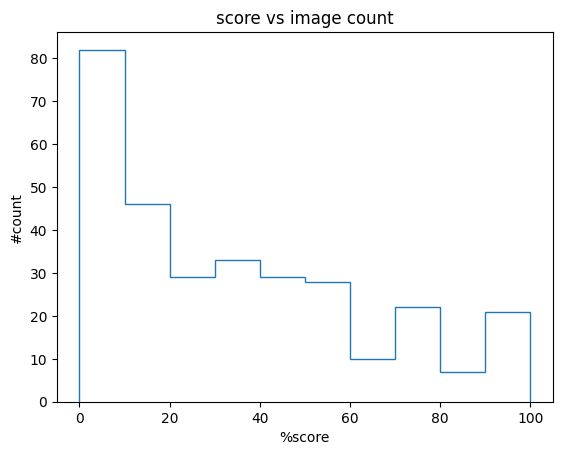

In [90]:
from matplotlib import pyplot as plt
import numpy as np

results = best_model[2]
scores = [(k, results[k]['score']) for k in results.keys()]
scores.sort(key=lambda a: a[1])


counts, bins = np.histogram(np.array([float(s[1]) for s in scores])*100)
plt.stairs(counts, bins)
plt.xlabel('%score')
plt.ylabel('#count')
plt.title('score vs image count')
plt.show()

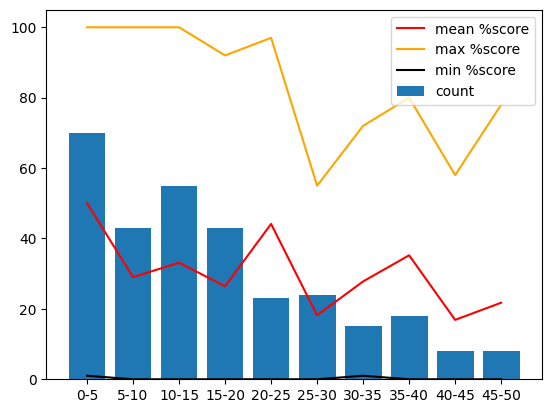

In [127]:
from matplotlib import pyplot as plt
import numpy as np

results = best_model[2]
fs = [ np.array([
        float(results[k]['score'])*100, 
        len(results[k]['labels']),
        len(results[k]['actual_labels'])
    ]) for k in results.keys()]

fs_df_all = pd.DataFrame(fs, columns = ['score', 'n_faces_pred', 'n_faces_actual'])
fs_df_actual = fs_df_all[['score', 'n_faces_actual']]

#the dataset has max of 50 for any image
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50']
fs_df_actual['bin'] = pd.cut(x = fs_df_actual['n_faces_actual'], bins = bins, labels = labels, include_lowest = True)

fs_df_actual = fs_df_actual.groupby(by = 'bin').agg(
    {'n_faces_actual':'count', 'score':[ np.mean, np.max, np.min ]}).rename(
        columns={
            'n_faces_actual': 'count', 
            'mean': 'mean_score',
            'max': 'max_score',
            'min': 'min_score'
            }
        ).reset_index()
fs_df_actual.columns = ['_'.join(col) for col in fs_df_actual.columns.values]

plt.bar(fs_df_actual["bin_"], fs_df_actual["count_count"], label = "count") 
plt.plot(fs_df_actual["bin_"], fs_df_actual["score_mean_score"], label = "mean %score", color='red') 
plt.plot(fs_df_actual["bin_"], fs_df_actual["score_max_score"], label = "max %score", color='orange') 
plt.plot(fs_df_actual["bin_"], fs_df_actual["score_min_score"], label = "min %score", color='black') 
plt.legend() 
plt.show()

In [125]:
results = best_model[2]
scores = [(k, results[k]['score']) for k in results.keys()]
scores.sort(key=lambda a: a[1])

scores = np.array(scores)
print(
    "n_scores =", len(scores), 
    "low_score =", scores[0][1], 
    "mid_score =", scores[len(scores)//2][1], 
    "high_score =", scores[len(scores)-1][1]
)

low_scores = scores[0:4]
mid_scores = scores[len(scores)//2-2:len(scores)//2+2]
high_scores = scores[-4:]
print(
    "low scores =", [s[1] for s in low_scores], 
    "\nmid scores =", [s[1] for s in mid_scores], 
    "\nhigh scores =", [s[1] for s in high_scores])

n_scores = 307 low_score = 0.0 mid_score = 0.27 high_score = 1.0
low scores = ['0.0', '0.0', '0.0', '0.0'] 
mid scores = ['0.26', '0.27', '0.27', '0.27'] 
high scores = ['1.0', '1.0', '1.0', '1.0']


In [126]:
from pathlib import Path
from typing import Any
from imagewrapper import CVImageWrapper

import numpy as np
from matplotlib import pyplot as plt

def get_img_paths(scores):
    return [s[0] for s in scores]

class GroundTruthImage:
    def __init__(self, ds=coco_ds) -> None:
        self.ds = coco_ds
    
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        image_name = Path(args[0]).name
        tuples = coco_ds.get_bbox(image_name)
        bboxes = np.array([t[1] for t in tuples])
        labels = [t[0] for t in tuples]
        img = CVImageWrapper(args[0])
        img.annotate(bboxes, labels)
        return img

class  ImageOrganizer:
    def __init__(self, test_results=results, truth_dataset=coco_ds) -> None:
        self.test_results = test_results
        self.truth_dataset = GroundTruthImage(truth_dataset)
        self.ds = truth_dataset
    
    def fill_axis(self, ax, img: CVImageWrapper, score, label_counts):
        ax.imshow(img.printformat(), cmap = plt.cm.Spectral)
        ax.set_axis_off()
        ax.set_title('score = {}'.format(score))
        labels_str = ', '.join(['{}={}'.format(k,v) for (k,v) in label_counts])
        ax.text(0, 0, labels_str, fontsize=8)
        
    def organize(self, group_truths, predicts) -> None:
        for i, _ in enumerate(group_truths):
            fig, (tax1, pax1)  = plt.subplots(1, 2)
                
            (img, score, label_counts)  = group_truths[i]
            self.fill_axis(tax1, img, score, label_counts)
            
            (img, score, label_counts)  = predicts[i]
            self.fill_axis(pax1, img, score, label_counts)
            
        plt.show(block=True)
    
    def to_label_counts(self, labels):
        label_counts = {}
        for l in labels:
            if l in label_counts.keys():
                label_counts[l] += 1
            else:
                label_counts[l] = 1
        
        label_counts = [(k, label_counts[k]) for k in label_counts.keys()]
        return sorted(label_counts, key=lambda r: r[0])
        
    def collect_and_organize(self, scores):
        truth_tuples = []
        prdict_tuples = []
        
        img_paths = [s[0] for s in scores]
        for img_path in img_paths:
            truth_image = self.truth_dataset(img_path)
            image_name = Path(img_path).name
            tuples = self.ds.get_bbox(image_name)
            truth_tuples.append((
                truth_image, 
                1.0, 
                self.to_label_counts([t[0] for t in tuples])))
            
            pred_image = CVImageWrapper(img_path)
            pred_image.annotate(
                results[img_path]['bboxes'], 
                results[img_path]['labels'])
            prdict_tuples.append((
                pred_image, 
                results[img_path]['score'], 
                self.to_label_counts(results[img_path]['labels'])))
        
        self.organize(truth_tuples, prdict_tuples)

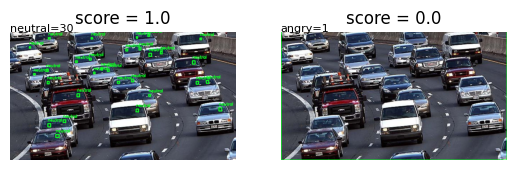

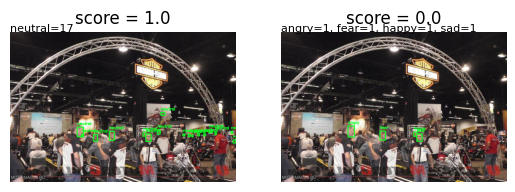

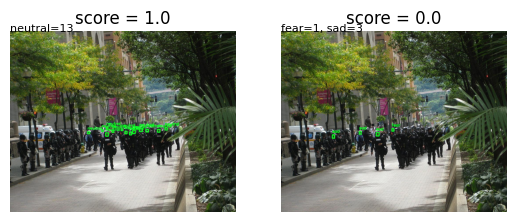

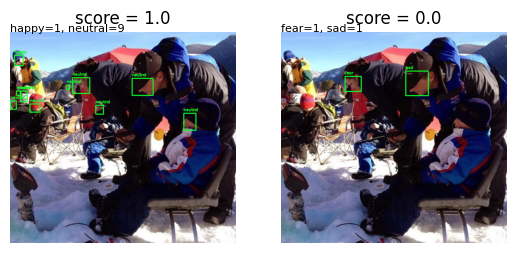

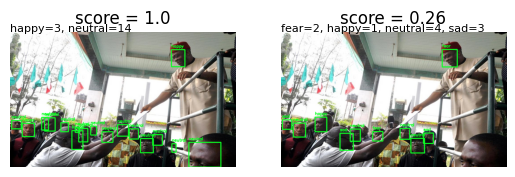

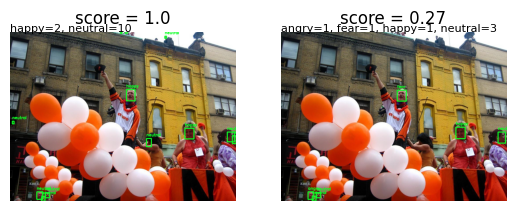

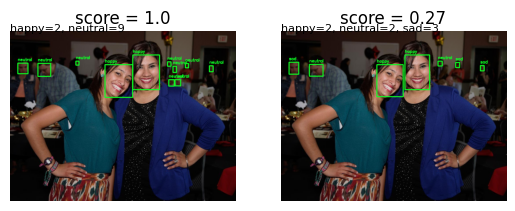

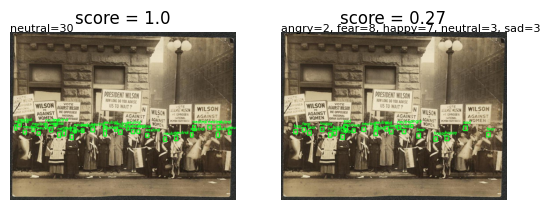

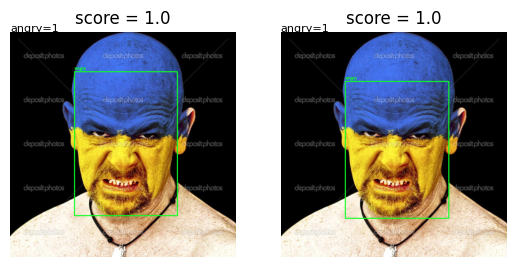

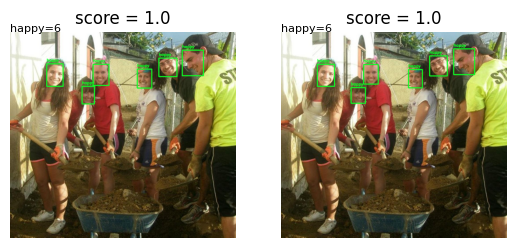

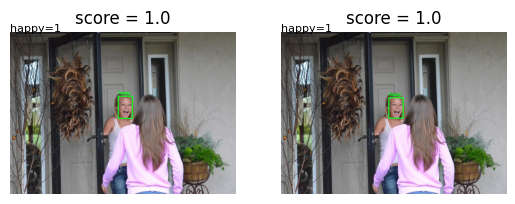

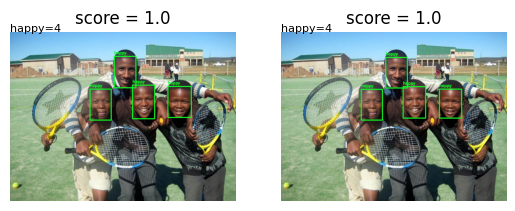

In [128]:
organizer = ImageOrganizer(results, coco_ds)

organizer.collect_and_organize(low_scores)
organizer.collect_and_organize(mid_scores)
organizer.collect_and_organize(high_scores)

# 6. Conclusion

**Dataset**

The varied collection of the WIDERFACE dataset has been presented with how it can be used to annotate facial expressions in roboflow and evaluate the model to detect facial expression. The dataset seems to have low resolution pictures, where certain faces are not clearly visible and it was hard to annotate the facial expression. Due to which the dataset have lot of neutral facial expression. The distribution of the facial expressions in the dataset is not taken into account as we are using the dataset in the inference phase (again the training phase). 

Based on the model papers, the dataset they are trained on have unbalanced counts of facial expressions - happy being more in count. In my view, it is expected the model give preference to happy emotion compared to others. The training details of the model used here are unknown but we can take hint from the high scored images having happy faces mainly.

**Model**

Opensourced deepface emotions model is used to detect facial expressions. The model leverages well known models as backend to detect faces. I have influenced the model results based on emotion threshold to bias the model towards predicting 'neutral' when it is not confident enough. This is done in order to mimic my behavior (chose neutral when I was not confident enough) while annotating the faces. I tried with 0.25, 0.5, & 0.75 values but the results showed no difference, which means the model has a good confidence score for each of the emotion predicted including 'neutral'.


**Results**

BLEU-1 metric gave a easy way to express the performance of the model as we can see in the images with low, med, and high scores. Models scored low on images where #faces detected and facial expression composition is higly off from actuals.

Out of the available backends, RetinaFace showed better results in detecting the faces which resulted in higher BLEU-1 score: 0.25 followed by mtccn with score of 0.15. Other models were not close enough.
![Alt text](image.png)

The (best) model did better on images with low number of faces. As shown in below graph, the mean score is dropped slightly as number of faces goes up. The model seems to dabble detecting the faces which are obstructed or very samll in size which can be seen in the images with low score.
![Alt text](image-2.png)

The score distribution over number of images can be seen here.
![Alt text](image-1.png)

# 7. Challenges

- Considerable amount of time went in coming up with approach to showcase how to measure the model given in the context of predicting group cohesion. I went through many papers trying to understand how the facial expression features are taken as input to the models predicting group cohesion. This gave me an idea on evaluating composition of facial expressions which I think BLEU-1 scores perfectly aims at doing so.

- Understanding the python code constructs to deal with datasets and interacting with roboflow tool awful time as roboflow python api seems to be very fragile. The errors were not clear and there are lot of features missing on the python api compared to the web interface. I ended up coding different dataset formats (COCO, VOC, Yolo) to handle an issue on annotating bboxes.

- It took around 4-5 hours to annotate the faces on the roboflow.com. The roboflow has a very clean interface but it doesn't have a group selection to annotate same label, so it was mundane a bit. As I was going though this process, I see lot of images are low resolution and have obstructed/really-small faces where the facial expression was not clear enough for human eye. I labeled these faces with neutral.

# 8. Future Work

- Dig deeper into the images where the model scored low which could be due to human error. The dataset can be selectively chosed to have images with clear faces with different emotions to better evaluate the model where human judgement is better.

- Understand and Implement mulit-modal with [PAtt-Lite](https://arxiv.org/pdf/2306.09626v1.pdf) for FER and YoloV8, [TinaFace](https://arxiv.org/pdf/2011.13183.pdf) models for detecting faces

- Most of the time the images are taken in shots of 3-10, will try stacking the similar images and predicting the emotions on the stack instead of one single image. The open source model supports video stream, so can try exploring predicting face emotions on video stream

- Explore sklearn or other modules to see if they have pluggable architecture to run different models and evaluate them based on scores.

- Understand and Implement group cohesion models ([1](https://arxiv.org/pdf/1910.01197.pdf), [2](https://arxiv.org/pdf/1812.11771.pdf), [3](https://cs.uwaterloo.ca/~jhoey/papers/DhallEmotiW2017.pdf)) which use image level and face level features to predict group cohesion.

- Research if same backend can be used to generate features for detecting both faces and expressions